In [7]:
import tensorflow as tf
import numpy as np
from keras.datasets import mnist

# 데이터 준비
(_, _), (test_images, test_labels) = mnist.load_data()
test_images = test_images.reshape(-1, 28 * 28) / 255.0

# 모델 불러오기
model = tf.keras.models.load_model('./weight/model.h5')

# 레이어 객체
hidden2_layer = model.layers[1]  # 두 번째 히든 레이어
output_layer = model.layers[2]   # 출력 레이어

# 중간 입력값 추출 모델
hidden2_input_model = tf.keras.Model(inputs=model.input, outputs=hidden2_layer.input)
output_input_model = tf.keras.Model(inputs=model.input, outputs=output_layer.input)

# 전체 테스트셋에 대해 추출
hidden2_inputs = hidden2_input_model.predict(test_images, verbose=1)  # shape: (10000, 300)
output_inputs = output_input_model.predict(test_images, verbose=1)    # shape: (10000, 100)

# 라벨별로 그룹화하여 통계 계산
num_classes = 10
hidden2_stats = {}
output_stats = {}

for label in range(num_classes):
    idx = np.where(test_labels == label)[0]
    hidden2_group = hidden2_inputs[idx]   # shape: (N, 300)
    output_group = output_inputs[idx]     # shape: (N, 100)
    
    # 예시: 평균과 분산 계산
    hidden2_stats[label] = {
        'mean': np.mean(hidden2_group, axis=0),
        'std': np.std(hidden2_group, axis=0)
    }
    output_stats[label] = {
        'mean': np.mean(output_group, axis=0),
        'std': np.std(output_group, axis=0)
    }

# 예시: 0번 라벨의 2번째 히든 레이어 입력값 평균 shape
print("0번 라벨의 2번째 히든 레이어 입력값 평균 shape:", hidden2_stats[0]['mean'].shape)
print("0번 라벨의 출력 레이어 입력값 평균 shape:", output_stats[0]['mean'].shape)

313/313 [==============================] - 0s 457us/step
0번 라벨의 2번째 히든 레이어 입력값 평균 shape: (300,)
0번 라벨의 출력 레이어 입력값 평균 shape: (100,)


In [8]:
# 첫 번째, 두 번째 히든 레이어의 출력값 추출 모델
hidden1_output_model = tf.keras.Model(inputs=model.input, outputs=model.layers[0].output)
hidden2_output_model = tf.keras.Model(inputs=model.input, outputs=model.layers[1].output)

hidden1_outputs = hidden1_output_model.predict(test_images)
hidden2_outputs = hidden2_output_model.predict(test_images)

313/313 [==============================] - 0s 467us/step


# 각 레이블 0~9에 따른 두 히든 레이어의 합의 분포

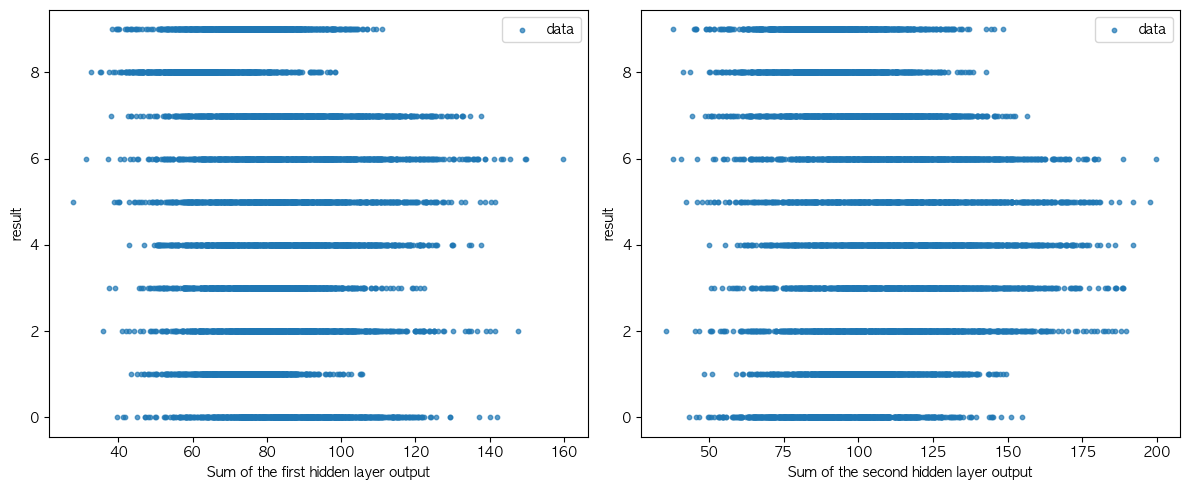

In [9]:
import matplotlib.pyplot as plt

# hidden1_outputs, hidden2_outputs: 각 히든 레이어의 출력값 (예: (10000, 300), (10000, 100))
# test_labels: (10000,)

# 첫 번째 히든 레이어 출력값 합
hidden1_sum = np.sum(hidden1_outputs, axis=1)  # (10000,)
# 두 번째 히든 레이어 출력값 합
hidden2_sum = np.sum(hidden2_outputs, axis=1)  # (10000,)

plt.figure(figsize=(12, 5))

# 첫 번째 히든 레이어 출력값 합 vs 라벨
plt.subplot(1, 2, 1)
plt.scatter(hidden1_sum, test_labels, label='data', alpha=0.7, s=10)
plt.xlabel('Sum of the first hidden layer output')
plt.ylabel('result')
plt.legend()

# 두 번째 히든 레이어 출력값 합 vs 라벨
plt.subplot(1, 2, 2)
plt.scatter(hidden2_sum, test_labels, label='data', alpha=0.7, s=10)
plt.xlabel('Sum of the second hidden layer output')
plt.ylabel('result')
plt.legend()

plt.tight_layout()
plt.show()

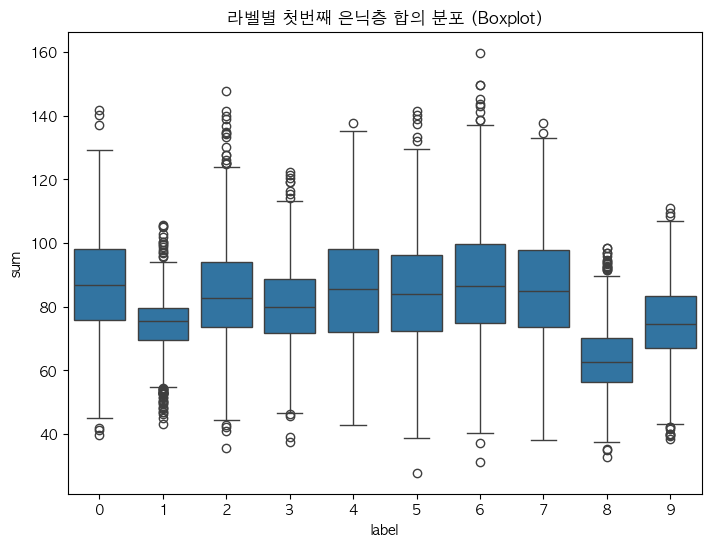

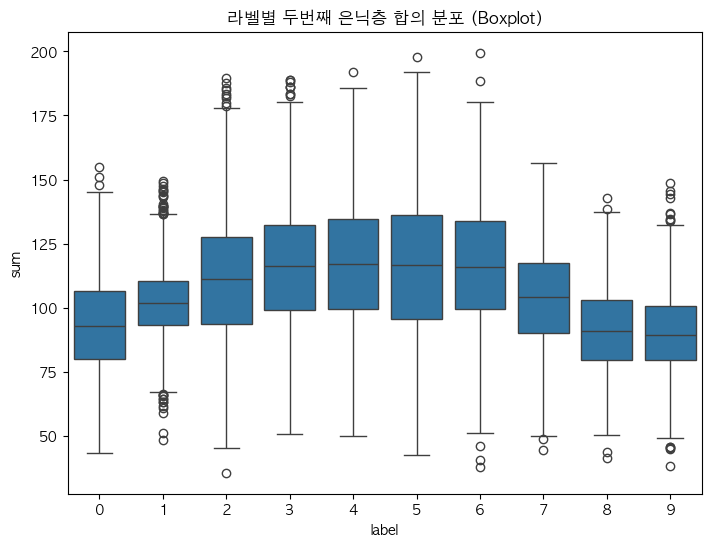

In [10]:
import seaborn as sns
import pandas as pd
plt.rcParams['font.family'] ='AppleGothic'
plt.rcParams['axes.unicode_minus'] =False

df1 = pd.DataFrame({'sum': hidden1_sum, 'label': test_labels})
df2 = pd.DataFrame({'sum': hidden2_sum, 'label': test_labels})

plt.figure(figsize=(18, 6))
plt.subplot(1, 2, 1)
sns.boxplot(x='label', y='sum', data=df1)
plt.title('라벨별 첫번째 은닉층 합의 분포 (Boxplot)')
plt.show()

plt.figure(figsize=(18, 6))
plt.subplot(1, 2, 2)
sns.boxplot(x='label', y='sum', data=df2)
plt.title('라벨별 두번째 은닉층 합의 분포 (Boxplot)')
plt.show()

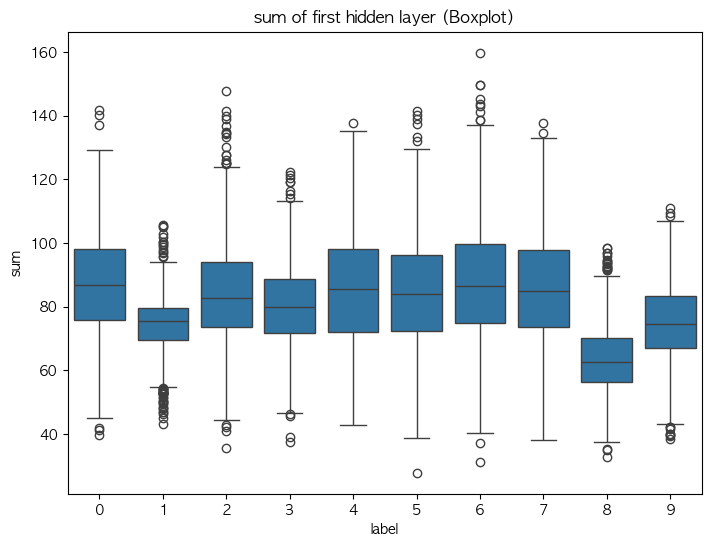

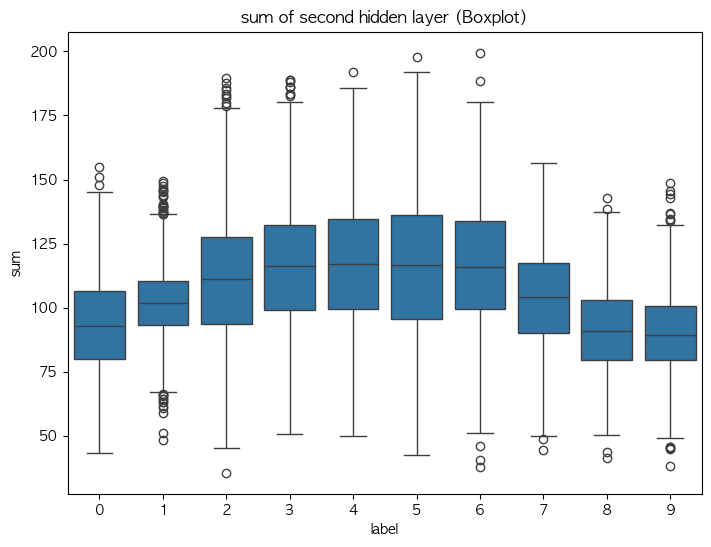

In [11]:
plt.figure(figsize=(18, 6))
plt.subplot(1, 2, 1)
sns.boxplot(x='label', y='sum', data=df1)
plt.title('sum of first hidden layer (Boxplot)')
plt.show()

plt.figure(figsize=(18, 6))
plt.subplot(1, 2, 2)
sns.boxplot(x='label', y='sum', data=df2)
plt.title('sum of second hidden layer (Boxplot)')
plt.show()

### ANOVA(분산분석, Analysis of Variance)
여러 그룹(여기서는 라벨별) 간 평균의 차이가 통계적으로 유의미한지 검정합니다.

귀무가설: 모든 라벨 그룹의 은닉층 합 평균이 같다.

대립가설: 적어도 한 그룹의 평균이 다르다.

p-value가 0.05보다 작으면 라벨별로 유의미한 차이가 있다고 볼 수 있습니다.

In [12]:
from scipy.stats import f_oneway

# 라벨별로 은닉층 합 분리
grouped1 = [hidden1_sum[test_labels == i] for i in range(10)]
f_stat, p_value = f_oneway(*grouped1)
print(f"F-통계량: {f_stat}, p-value: {p_value}")

grouped2 = [hidden2_sum[test_labels == i] for i in range(10)]
f_stat, p_value = f_oneway(*grouped2)
print(f"F-통계량: {f_stat}, p-value: {p_value}")

F-통계량: 263.062247482315, p-value: 0.0
F-통계량: 262.5845819214439, p-value: 0.0


In [13]:
from scipy.stats import ks_2samp


labels = np.unique(test_labels)
num_labels = len(labels)

alpha = 0.05 # 유의 수준

print("hidden1_sum 분포 비교 (Kolmogorov-Smirnov 검정):\n")

for i in range(num_labels):
    for j in range(i + 1, num_labels):
        label1 = labels[i]
        label2 = labels[j]

        data1 = hidden1_sum[test_labels == label1]
        data2 = hidden1_sum[test_labels == label2]

        if len(data1) < 2 or len(data2) < 2:
            print(f"레이블 {label1}과 레이블 {label2} 비교: 데이터 부족으로 검정 불가")
            continue

        ks_statistic, p_value = ks_2samp(data1, data2)

        print(f"레이블 {label1} vs 레이블 {label2}:")
        print(f"  KS Statistic: {ks_statistic:.4f}")
        print(f"  P-value: {p_value:.4f}")

        if p_value < alpha:
            print(f"  결론: 유의수준 {alpha}에서 레이블 {label1}과 레이블 {label2}의 분포는 서로 다릅니다.")
        else:
            print(f"  결론: 유의수준 {alpha}에서 레이블 {label1}과 레이블 {label2}의 분포는 서로 다르다고 할 수 없습니다.")
        print("-" * 30)


hidden1_sum 분포 비교 (Kolmogorov-Smirnov 검정):

레이블 0 vs 레이블 1:
  KS Statistic: 0.4876
  P-value: 0.0000
  결론: 유의수준 0.05에서 레이블 0과 레이블 1의 분포는 서로 다릅니다.
------------------------------
레이블 0 vs 레이블 2:
  KS Statistic: 0.1146
  P-value: 0.0000
  결론: 유의수준 0.05에서 레이블 0과 레이블 2의 분포는 서로 다릅니다.
------------------------------
레이블 0 vs 레이블 3:
  KS Statistic: 0.2343
  P-value: 0.0000
  결론: 유의수준 0.05에서 레이블 0과 레이블 3의 분포는 서로 다릅니다.
------------------------------
레이블 0 vs 레이블 4:
  KS Statistic: 0.0974
  P-value: 0.0002
  결론: 유의수준 0.05에서 레이블 0과 레이블 4의 분포는 서로 다릅니다.
------------------------------
레이블 0 vs 레이블 5:
  KS Statistic: 0.0947
  P-value: 0.0004
  결론: 유의수준 0.05에서 레이블 0과 레이블 5의 분포는 서로 다릅니다.
------------------------------
레이블 0 vs 레이블 6:
  KS Statistic: 0.0598
  P-value: 0.0593
  결론: 유의수준 0.05에서 레이블 0과 레이블 6의 분포는 서로 다르다고 할 수 없습니다.
------------------------------
레이블 0 vs 레이블 7:
  KS Statistic: 0.0755
  P-value: 0.0062
  결론: 유의수준 0.05에서 레이블 0과 레이블 7의 분포는 서로 다릅니다.
------------------------------
레이블 0 vs 레이블 8:


In [14]:
print("hidden2_sum 분포 비교 (Kolmogorov-Smirnov 검정):\n")

for i in range(num_labels):
    for j in range(i + 1, num_labels):
        label1 = labels[i]
        label2 = labels[j]

        data1 = hidden2_sum[test_labels == label1]
        data2 = hidden2_sum[test_labels == label2]

        if len(data1) < 2 or len(data2) < 2:
            print(f"레이블 {label1}과 레이블 {label2} 비교: 데이터 부족으로 검정 불가")
            continue

        ks_statistic, p_value = ks_2samp(data1, data2)

        print(f"레이블 {label1} vs 레이블 {label2}:")
        print(f"  KS Statistic: {ks_statistic:.4f}")
        print(f"  P-value: {p_value:.4f}")

        if p_value < alpha:
            print(f"  결론: 유의수준 {alpha}에서 레이블 {label1}과 레이블 {label2}의 분포는 서로 다릅니다.")
        else:
            print(f"  결론: 유의수준 {alpha}에서 레이블 {label1}과 레이블 {label2}의 분포는 서로 다르다고 할 수 없습니다.")
        print("-" * 30)


hidden2_sum 분포 비교 (Kolmogorov-Smirnov 검정):

레이블 0 vs 레이블 1:
  KS Statistic: 0.2599
  P-value: 0.0000
  결론: 유의수준 0.05에서 레이블 0과 레이블 1의 분포는 서로 다릅니다.
------------------------------
레이블 0 vs 레이블 2:
  KS Statistic: 0.3465
  P-value: 0.0000
  결론: 유의수준 0.05에서 레이블 0과 레이블 2의 분포는 서로 다릅니다.
------------------------------
레이블 0 vs 레이블 3:
  KS Statistic: 0.4093
  P-value: 0.0000
  결론: 유의수준 0.05에서 레이블 0과 레이블 3의 분포는 서로 다릅니다.
------------------------------
레이블 0 vs 레이블 4:
  KS Statistic: 0.4294
  P-value: 0.0000
  결론: 유의수준 0.05에서 레이블 0과 레이블 4의 분포는 서로 다릅니다.
------------------------------
레이블 0 vs 레이블 5:
  KS Statistic: 0.4021
  P-value: 0.0000
  결론: 유의수준 0.05에서 레이블 0과 레이블 5의 분포는 서로 다릅니다.
------------------------------
레이블 0 vs 레이블 6:
  KS Statistic: 0.4169
  P-value: 0.0000
  결론: 유의수준 0.05에서 레이블 0과 레이블 6의 분포는 서로 다릅니다.
------------------------------
레이블 0 vs 레이블 7:
  KS Statistic: 0.2290
  P-value: 0.0000
  결론: 유의수준 0.05에서 레이블 0과 레이블 7의 분포는 서로 다릅니다.
------------------------------
레이블 0 vs 레이블 8:
  KS Stat